<a href="https://colab.research.google.com/github/JunruL/Variational-Autoencoder/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fetch the Data

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle datasets download -d playlist/mnistzip
!unzip mnistzip.zip

### Import Libraries

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np
from torch import nn

### Creat a Custom Dataset

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, data_lst: list, label_lst: list):
        self.data_lst = data_lst
        self.label_lst = label_lst

    def __len__(self):
        return len(self.data_lst)

    def __getitem__(self, idx):
        image = cv.imread(data_lst[idx], 0)
        image = np.expand_dims(image, axis=2)
        image = ToTensor()(image)
        label = label_lst[idx]
        return image, label

In [ ]:
data_lst = []
label_lst = []
for number in range(10):
  number_lst = os.listdir('./mnist_png/train/' + str(number))
  data_lst += ['./mnist_png/train/' + str(number) + '/' + str(file) for file in number_lst]
  label_lst += [number for _ in range(len(number_lst))]

In [ ]:
dataset = CustomImageDataset(number_lst, label_lst)
idx = 10000
image, label = dataset[idx]
print(label)

1


In [ ]:
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
for data in train_dataloader:
  sample_data, sample_label = data
  print(sample_data.shape)
  print(sample_label.shape)

### Build Neural Networks

Inference Model (Encoder / recognition Model): 

$$q_{\phi} (z | x)$$

We use a multivariate normal distribution for it: 

$$q_{\phi} (z | x) = \mathcal{N} (\vec{z}; \vec{\mu}, \text{diag}(\vec{\sigma}))$$

, which means

$$z \sim \mathcal{N} (\vec{\mu}, \text{diag}(\vec{\sigma}))$$

To make the the encoder differentiable, we can use the reparameterization trick: 

$$\vec{\epsilon} \sim \mathcal{N} (0, 1)$$

$$(\vec{\mu}, \log \vec{\sigma}) = \text{EncoderNeuralNet}_{\phi} (\vec{x})$$

$$\vec{z} = \vec{\mu} + \vec{\sigma} \odot \vec{\epsilon} $$

, where $\odot$ is the element-wise product.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28*28, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.mean_layer = nn.Linear(128, 128)
        self.log_sd_layer = nn.Linear(128, 128)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        mean = self.mean_layer(x)
        sd = torch.exp(self.log_sd_layer(x))

        # random vector from Normal distribution
        epsilon = torch.randn_like(sd)
        z = mean + sd * epsilon
        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()   
        self.layer1 = nn.Linear(128, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, 28*28)
        self.relu = nn.ReLU()

    def forward(self, z):
        z = self.layer1(z)
        z = self.relu(z)
        z = self.layer2(z)
        z = self.relu(z)
        z = self.layer3(z)
        z = self.relu(z)

        z = torch.reshape(z, (z.shape[0], 1, 28, 28))
        return z

In [ ]:
for data in train_dataloader:
  sample_data, sample_label = data
  break

In [ ]:
encoder = Encoder()
z = encoder(sample_data)
z.shape

torch.Size([32, 128])

In [ ]:
decoder = Decoder()
x = decoder(z)
x.shape

torch.Size([32, 1, 28, 28])

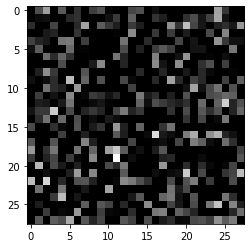

In [ ]:
def generate_img(decoder: Decoder, z: np.array):
    """Note: the batchsize of z = 1
    """
    return decoder(z)[0][0].detach().numpy()

img = generate_img(decoder, torch.randn(1, 128))
plt.imshow(img, cmap='gray')

### ELBO (Evidence Lower Bound)

Evidence lower bound (also called variational lower bound), is the optimization objective of the VAE. For any inference model $q_{\phi}(z|x)$, 

\begin{align*}
\log p_{\theta}(x) &= \mathbb{E}_{q_{\phi}(z|x)} \big[\log p_{\theta}(x) \big]\\
&= \mathbb{E}_{q_{\phi}(z|x)} \Big[\log \frac{p_{\theta}(x, z)}{p_{\theta}(z|x)} \Big]\\
&= \mathbb{E}_{q_{\phi}(z|x)} \Bigg[\log \Big[ \frac{p_{\theta}(x, z)}{p_{\phi}(z|x)} \frac{p_{\phi}(z|x)}{p_{\theta}(z|x)}\Big] \Bigg]\\
&= \mathbb{E}_{q_{\phi}(z|x)} \Big[\log \frac{p_{\theta}(x, z)}{p_{\phi}(z|x)} \Big] + \mathbb{E}_{q_{\phi}(z|x)} \Big[\log \frac{p_{\phi}(z|x)}{p_{\theta}(z|x)} \Big]\\
&= \mathcal{L}_{\theta, \phi}(x) + D_{KL}(q_{\phi}(z|x) || q_{\theta}(z|x))\\
&\geq \mathcal{L}_{\theta, \phi}(x) \tag{since $D_{KL}(q_{\phi}(z|x) || q_{\theta}(z|x)) \geq 0$}
\end{align*}

, where 
*   $\mathcal{L}_{\theta, \phi}(x)$ is the variational lower bound or the evidence lower bound (ELBO)
*   $D_{KL}(q_{\phi}(z|x) || q_{\theta}(z|x))$ is the (KL) divergence between $q_{\phi}(z|x)$ and $q_{\theta}(z|x)$


Form the derivation above, we can see that the ELBO is a lower bound on the log-likeihood of the data. Also, since $$\mathcal{L}_{\theta, \phi}(x) = \log p_{\theta}(x) - D_{KL}(q_{\phi}(z|x) || q_{\theta}(z|x))$$,
maximizing the ELBO $\mathcal{L}_{\theta, \phi}(x)$ w.r.t. the parameters $\theta$ and $\phi$ will concurrently

*   maximize the marginal likelihood $p_{\theta}(x)$
*   minimize the KL divergence of the approximation $q_{\phi}(z|x)$ from the true posterior $p_{\theta}(z|x)$



